In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['activity', 'timestamp', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    data = pd.read_csv(file_path, header=None, names=column_names)
    return data


def feature_normalize(df):
    mu = np.mean(df, axis=0)
    sigma = np.std(df, axis=0)
    return (df - mu) / sigma


def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=8, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['a'], 'a')
    plot_axis(ax1, data['timestamp'], data['b'], 'b')
    plot_axis(ax2, data['timestamp'], data['c'], 'c')
    plot_axis(ax3, data['timestamp'], data['d'], 'd')
    plot_axis(ax4, data['timestamp'], data['e'], 'e')
    plot_axis(ax5, data['timestamp'], data['f'], 'f')
    plot_axis(ax6, data['timestamp'], data['g'], 'g')
    plot_axis(ax7, data['timestamp'], data['h'], 'h')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)


def segment_signal(data, window_size=90):
    segments = np.empty((0, window_size, 8))
    labels = np.empty(0)
    for (start, end) in windows(data['timestamp'], window_size):
        a = data["a"][start:end]
        b = data["b"][start:end]
        c = data["c"][start:end]
        d = data["d"][start:end]
        e = data["e"][start:end]
        f = data["f"][start:end]
        g = data["g"][start:end]
        h = data["h"][start:end]
        if len(data['timestamp'][start:end]) == window_size:
            segments = np.vstack([segments, np.dstack([a, b, c, d, e, f, g, h])])
            labels = np.append(labels, stats.mode(data["activity"][start:end])[0][0])
    return segments, labels


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)


def depth_wise_convert_2d(x, weights):
    return tf.nn.depthwise_conv2d(x, weights, [1, 1, 1, 1], padding='VALID')


def apply_depth_wise_conversion(x, kernel_size, num_channels, depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depth_wise_convert_2d(x, weights), biases))


def apply_max_pool(x, kernel_size, stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], strides=[1, 1, stride_size, 1], padding='VALID')


In [3]:
df = read_data('data/myo/myo_data.csv')

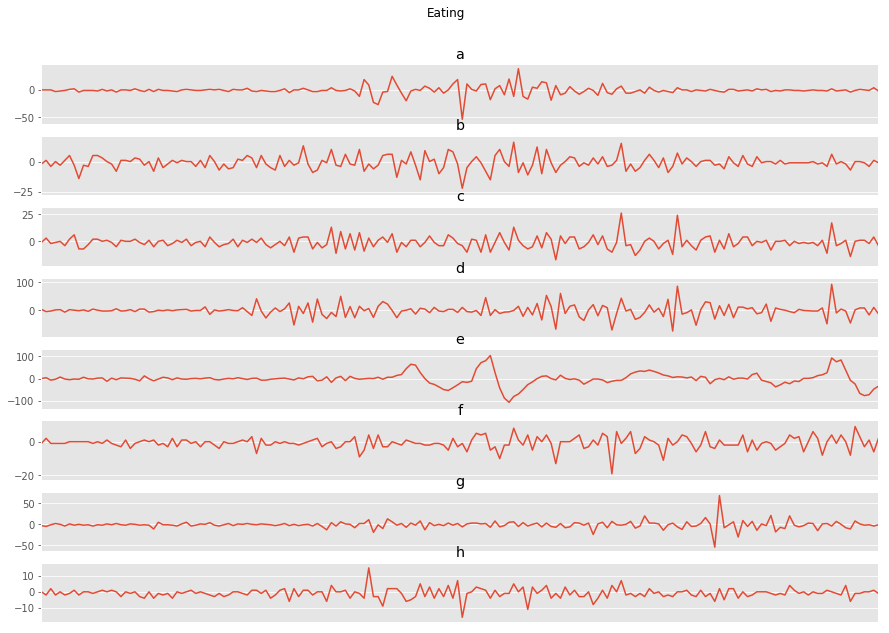

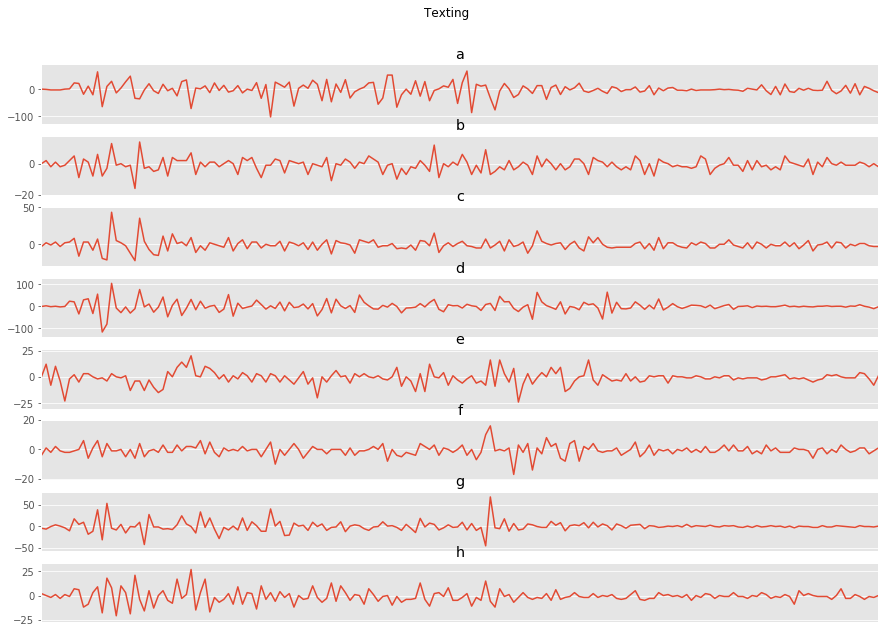

In [4]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

In [6]:
segments, labels = segment_signal(df)
labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)
reshaped_segments = segments.reshape(len(segments), 1, 90, 8)


In [7]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.80
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [8]:
input_height = 1
input_width = 90
num_labels = 2
num_channels = 8

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 50

total_batches = train_x.shape[0] // batch_size

In [9]:
X = tf.placeholder(tf.float32, shape=[None, input_height, input_width, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

c = apply_depth_wise_conversion(X, kernel_size, num_channels, depth)
p = apply_max_pool(c, 20, 2)
c = apply_depth_wise_conversion(p, 6, depth * num_channels, depth // 10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth // 10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1), f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)


In [10]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [11]:
cost_history = np.empty(shape=[1], dtype=float)

history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(1, training_epochs + 1):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y})
            cost_history = np.append(cost_history, c)

        acc_train = session.run(accuracy, feed_dict={X: train_x, Y: train_y})
        acc_test = session.run(accuracy, feed_dict={X: test_x, Y: test_y})

        history['train_acc'].append(acc_train)
        history['test_acc'].append(acc_test)

        if epoch != 1 and epoch % 10 != 0:
            continue

        print('Epoch: ' + str(epoch) + ', Training Accuracy: ' + str(acc_train) + ', Test Accuracy: ' + str(acc_test))


Epoch: 1, Training Accuracy: 0.4819649, Test Accuracy: 0.5
Epoch: 10, Training Accuracy: 0.72259134, Test Accuracy: 0.7373832
Epoch: 20, Training Accuracy: 0.79046035, Test Accuracy: 0.8046729
Epoch: 30, Training Accuracy: 0.8540579, Test Accuracy: 0.8635514
Epoch: 40, Training Accuracy: 0.8967727, Test Accuracy: 0.89813083
Epoch: 50, Training Accuracy: 0.92785954, Test Accuracy: 0.9214953


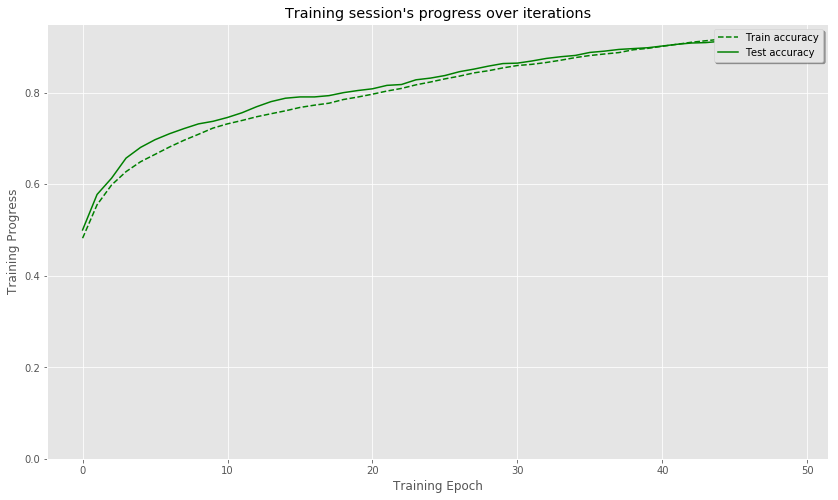

In [12]:
plt.figure(figsize=(14, 8))

plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()